<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/data/Quark_Gluon_reducted_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing

This notebook can be used to produce smaller versions of the Quark Gluon Dataset.
I used it to produce the 16x16 ECAL dataset.

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from matplotlib.colors import LogNorm

## load data

In [2]:
f = h5py.File("/content/quark-gluon_test-set_n139306.hdf5","r")

#f_val = h5py.File("../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
#f_train = h5py.File("../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")

There are three files:
- f : ~140000 samples
- f_train: ~800000 samples
- f_val: 10000 samples

Here, we are using only the f dataset with almost 140 000 samples

Each dataset consists of 4 variables:
- X_jets: energy deposited in the ECAL
- m0: inner tracker
- pt: energy deposited in the HCAL
- y: labels 0 or 1 for gluon and quark, respectively.


We use the dataset described in Andrews et al., which was derived from simulated data for QCD dijet production available on the CERN CMS Open Data Portal.

Events were generated and hadronized with the PYTHIA6 Monte Carlo event generator using the Z2∗ tune, which accounts for the difference in the hadronization patterns of quarks and gluons. The dataset consists of 933,206 3-channel 125 × 125 images, with half representing quarks and the other half gluons. Each of the three channels in the images corresponds to a specific component of the Compact Muon Solenoid (CMS) detector [53]:
- the inner tracking system (Tracks), which identifies charged particle tracks;
- the electromagnetic
calorimeter (ECAL), which captures energy deposits from electromagnetic particles;
- and the hadronic calorimeter (HCAL), which detects energy deposits from hadrons.

In [3]:
f.keys()

<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>

In [4]:
x_red = f.get('X_jets') #we only use the energy deposited in ECAL
y_red = f.get('y')

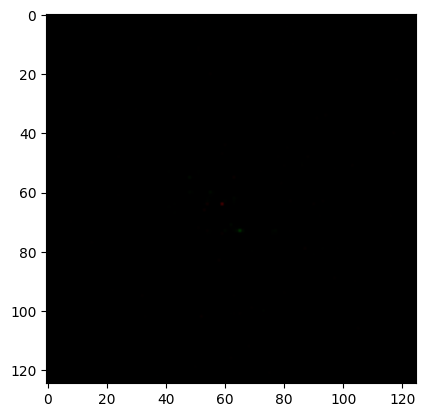

In [5]:
plt.imshow(x_red[0])

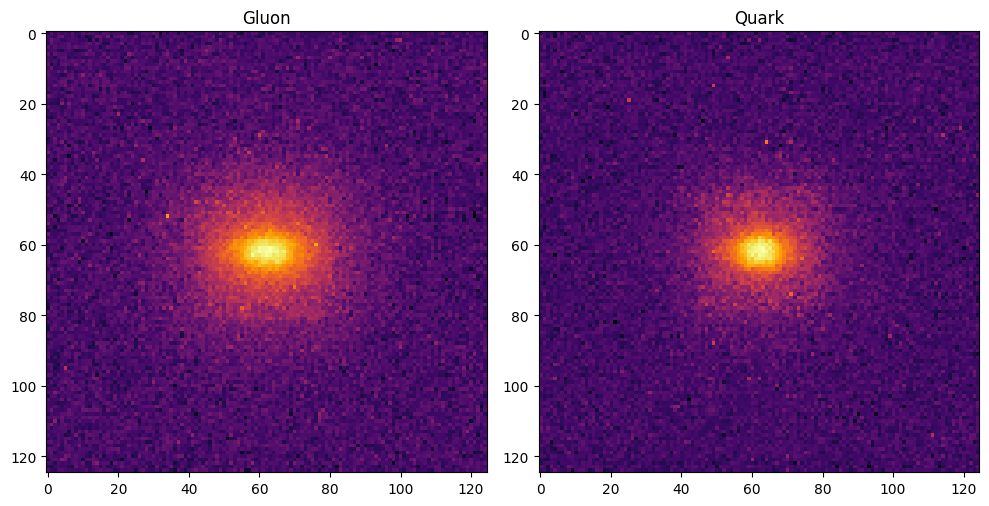

In [6]:
n_sample = 10000

# Calculate the average for each class
gluon_avg = np.mean(x_red[:n_sample][y_red[:n_sample] == 0], axis=0)
quark_avg = np.mean(x_red[:n_sample][y_red[:n_sample] == 1], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# mean values plot for gluons
axs[0].imshow(gluon_avg[:, :, 0], norm=LogNorm(), cmap='inferno')
axs[0].title.set_text('Gluon')

# mean values plot for quark
axs[1].imshow(quark_avg[:, :, 0], norm=LogNorm(), cmap='inferno')
axs[1].title.set_text('Quark')

fig.tight_layout()
plt.show()

## resize and safe to new file

The different methods that can be used to reduce the dimension.
Usually cropping first and then resizing should be the best.

In [7]:
def crop_and_resize(x, channel, scale, crop_fraction=0.8,meth="bilinear"):
    cropped = tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],125,125,1), crop_fraction)
    return tf.image.resize(cropped, (scale,scale), method=meth).numpy()

Fix some settings:

- batch size: how many samples to load into memory at once
- file name: name of output file
- output shape: shape the rescale images should have
- channel: which channel to use (in this case only ecal) - you could also rewrite to use all channels
- crop fraction: To what percent to crop down before rescaling

In [8]:
n_data = 50000

x_red = x_red[:n_data]
y_red = y_red[:n_data]

batch_size = 500
num_batches = x_red.shape[0] // batch_size
events = num_batches * batch_size
file_name = "QG_rescaled"
channel = 1
crop_fraction = 0.8

output_shape = (16,16,1)
events

50000

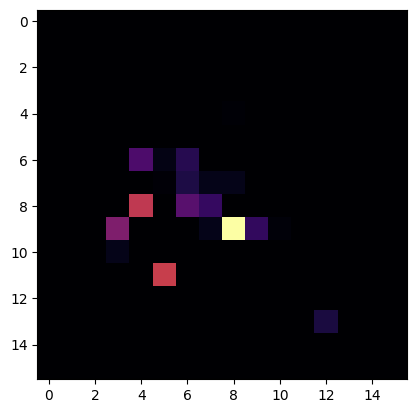

In [18]:
## example of the reduction using 5 samples
x_small = crop_and_resize(x_red[:5], channel, output_shape[0], crop_fraction=crop_fraction)

plt.imshow(x_small[0], cmap = 'inferno')

In [11]:
fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (events,) + output_shape, dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')

for i in range(int(num_batches)):
    y = y_red[i * batch_size: (i + 1) * batch_size]
    x = x_red[i * batch_size: (i + 1) * batch_size]

    x_small = crop_and_resize(x, channel, output_shape[0], crop_fraction=crop_fraction)

    div1 = np.max(x_small, axis=(1,2)).reshape((x.shape[0],1,1,1))
    div1[div1 == 0] = 1
    x_small = x_small / div1

    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_small.reshape((x_small.shape[0],)+output_shape)
    print("batch ",i,"/",num_batches, end="\r")

fnew.close()

## verify scaling

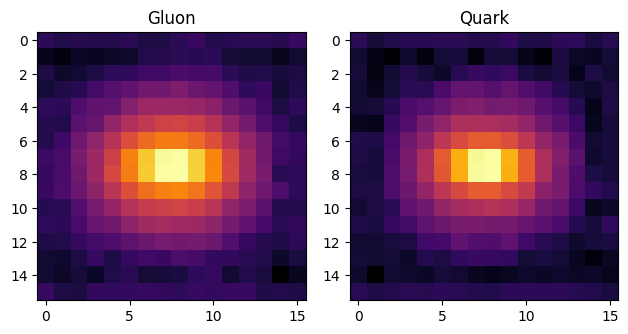

In [12]:
test = h5py.File(file_name,"r")

x_s = test.get('X')
y_s = test.get('y')

fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_s[y_s[:]==0],0),norm=LogNorm(), cmap='inferno')
axs[0].title.set_text('Gluon')

axs[1].imshow(np.average(x_s[y_s[:]==1],0),norm=LogNorm(), cmap='inferno')
axs[1].title.set_text('Quark')

fig.tight_layout()

test.close()

(50000, 16, 16, 1)

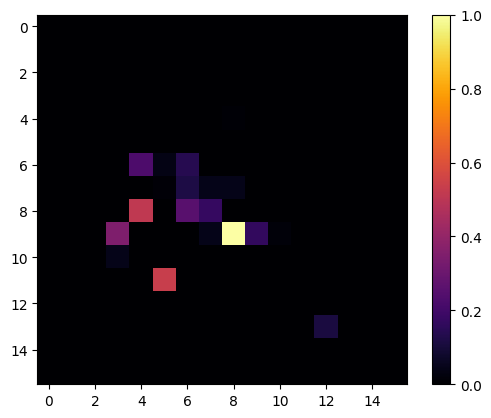

In [13]:
test = h5py.File(file_name,"r")

x_s = test.get('X')
y_s = test.get('y')


plt.imshow(x_s[0], cmap='inferno')
plt.colorbar()
x_s.shape

In [15]:
x_s.shape, y_s.shape

((50000, 16, 16, 1), (50000,))

In [16]:
import pandas as pd
pd.Series(y_s).value_counts()

1    25019
0    24981
Name: count, dtype: int64